## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import PIL.Image as PilImage

In [3]:
path = Path('/home/des/dev/src/segmentation')

In [4]:
path_lbl = path/'newlabels'
path_img = path/'images'

path_lbl

PosixPath('/home/des/dev/src/segmentation/newlabels')

## Data

In [5]:
fnames = get_image_files(path_img)

In [6]:
lbl_names = get_image_files(path_lbl)

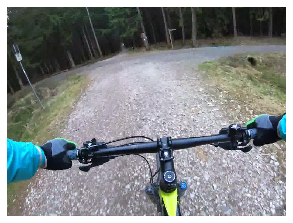

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

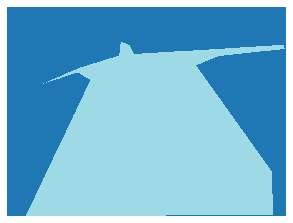

In [9]:
mask = open_mask(get_y_fn(img_f), div=False)
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1080, 1440]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Road', 'Background'], dtype='<U10')

In [12]:
mask.data.unique()


tensor([0, 1])

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=2, have 10746MB of GPU RAM free


In [14]:
classes2={'Road':38, 'Background':0}

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=classes2))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

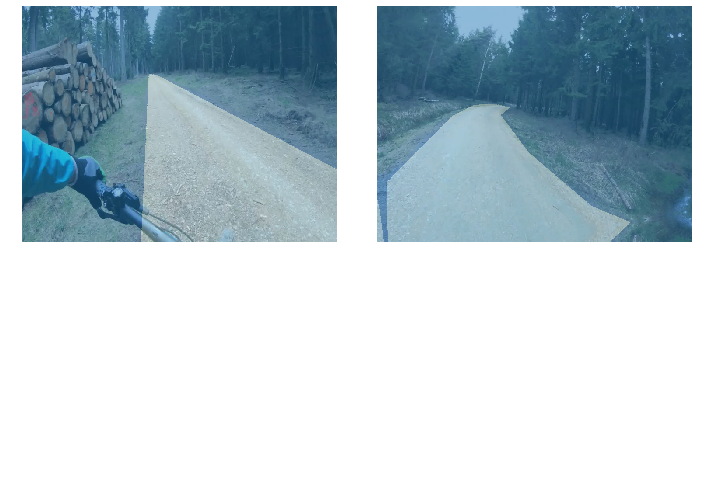

In [17]:
data.show_batch(2, figsize=(10,7))

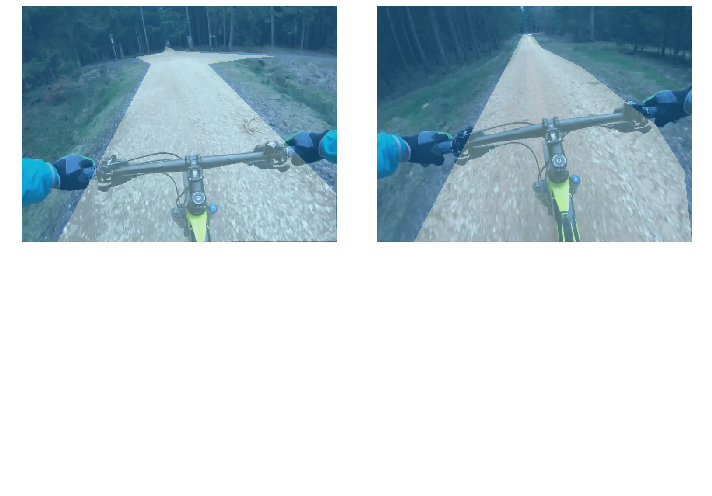

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [19]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def seg_accuracy(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [20]:
metrics=seg_accuracy

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [23]:
lr=3e-4

In [24]:
learn.load('stage-2');

In [25]:
path_full = path/'full'
full_names = get_image_files(path_full)
full_names[:3]

[PosixPath('/home/des/dev/src/segmentation/full/frame_000049.jpg'),
 PosixPath('/home/des/dev/src/segmentation/full/frame_000150.jpg'),
 PosixPath('/home/des/dev/src/segmentation/full/frame_000209.jpg')]

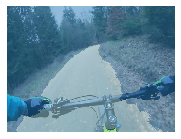

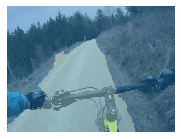

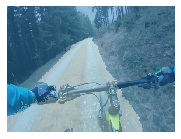

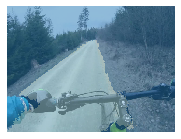

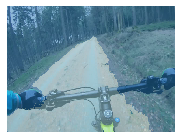

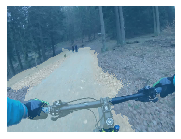

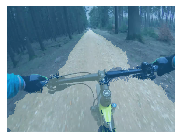

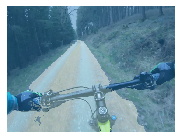

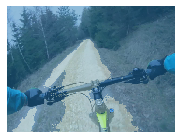

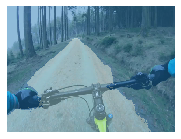

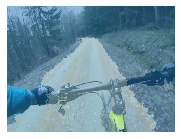

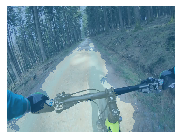

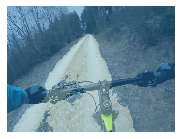

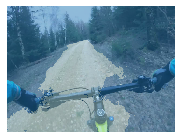

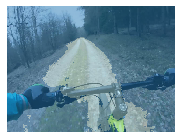

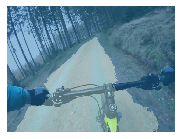

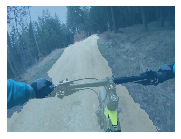

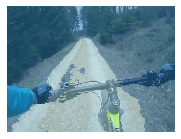

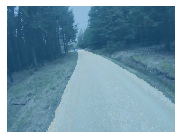

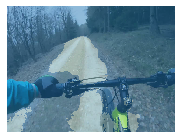

In [26]:
for img_file in full_names[200:220]:
   img = open_image(img_file)
   tfms, val_tfms = get_transforms()
   img = img.apply_tfms(tfms=get_transforms()[1], size=size)
   mask = learn.predict(img)[0]
   img.show(y=mask)
#   mask.save(str(img_file).replace('frame','mask'))